### Imports

In [1143]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import torch.nn as nn
import copy
from torch.optim.lr_scheduler import StepLR

### Setting random seeds

In [1146]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### Importing the data and forming the graphs

In [1149]:
mdna = pd.read_csv('mDM.csv')
mge = pd.read_csv('mGE.csv')
mcna = pd.read_csv('mCNA.csv')

In [1151]:
# Merge the dataframes on 'SAMPLE_ID' just to get the labels
merged_df = mdna.merge(mge, on='SAMPLE_ID').merge(mcna, on='SAMPLE_ID')

In [1153]:
# Separate features and labels
X_mdna = mdna.drop(columns=['SAMPLE_ID', 'CLASS'])
X_mge = mge.drop(columns=['SAMPLE_ID', 'CLASS'])
X_mcna = mcna.drop(columns=['SAMPLE_ID', 'CLASS'])
y = merged_df['CLASS']

In [1155]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

In [1157]:
# Convert numpy arrays to torch tensors
X_mdna_tensor = torch.tensor(X_mdna.values, dtype=torch.float32) # Convert DataFrame to NumPy array using .values
X_mge_tensor = torch.tensor(X_mge.values, dtype=torch.float32)   # Convert DataFrame to NumPy array using .values
X_mcna_tensor = torch.tensor(X_mcna.values, dtype=torch.float32)  # Convert DataFrame to NumPy array using .values

### Using DMCCA for dimensionality reduction

In [1310]:
class DMCCA(nn.Module):
    def __init__(self, input_dims, latent_dim, dropout=0.2):
        super(DMCCA, self).__init__()
        self.latent_dim = latent_dim
        self.encoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_dim, 128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, latent_dim)
            )
            for in_dim in input_dims
        ])
        self.decoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, 128),
                nn.ReLU(),
                nn.Linear(128, in_dim)
            )
            for in_dim in input_dims
        ])

    def forward(self, views):
        z_list = [encoder(view) for encoder, view in zip(self.encoders, views)]
        return z_list

    def get_joint_embedding(self, z_list):
        return torch.mean(torch.stack(z_list), dim=0)

    def reconstruct(self, z_joint):
        recons = [decoder(z_joint) for decoder in self.decoders]
        return recons

In [1312]:
# Instantiate DMCCA
input_dims = [X_mdna.shape[1], X_mge.shape[1], X_mcna.shape[1]]
latent_dim = 64  # You can tune this
dmcca = DMCCA(input_dims=input_dims, latent_dim=latent_dim)

# Optimizer
optimizer = torch.optim.Adam(dmcca.parameters(), lr=0.001)

# Train DMCCA (simple unsupervised loss: minimize pairwise distance between views)
num_epochs = 100
for epoch in range(num_epochs):
    dmcca.train()
    optimizer.zero_grad()

    zs = dmcca([X_mdna_tensor, X_mge_tensor, X_mcna_tensor])
    loss = sum(F.mse_loss(z1, z2) for i, z1 in enumerate(zs) for j, z2 in enumerate(zs) if i < j)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.0981
Epoch 10, Loss: 0.0247
Epoch 20, Loss: 0.0175
Epoch 30, Loss: 0.0119
Epoch 40, Loss: 0.0091
Epoch 50, Loss: 0.0070
Epoch 60, Loss: 0.0058
Epoch 70, Loss: 0.0048
Epoch 80, Loss: 0.0040
Epoch 90, Loss: 0.0035


### Constructing the shared latent space and upsampling using SMOTE

In [1314]:
dmcca.eval()
with torch.no_grad():
    zs = dmcca([X_mdna_tensor, X_mge_tensor, X_mcna_tensor])
X_dmcca = torch.stack(zs).mean(dim=0).numpy()  # Latent space

# Step 2: Apply SMOTE in latent space
from imblearn.over_sampling import SMOTE
X_smote, y_smote = SMOTE(random_state=42).fit_resample(X_dmcca, y)

In [1316]:
from sklearn.neighbors import kneighbors_graph

adj = kneighbors_graph(X_smote, n_neighbors=10, mode='distance', include_self=False)
similarities = 1 / (adj.data + 1e-8)
adj.data = similarities

edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

## Plotting the entire graph

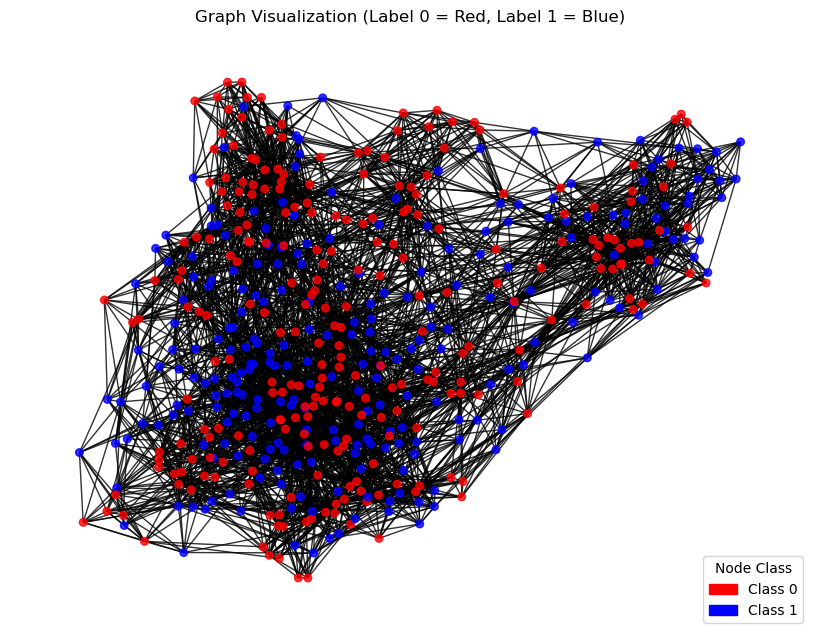

In [1172]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

# Convert PyG Data object to NetworkX graph
G = to_networkx(data, to_undirected=True)

# Create color list based on node labels
labels = data.y.cpu().numpy()
color_map = ['red' if label == 0 else 'blue' for label in labels]

# Draw graph with color-coded labels
plt.figure(figsize=(8, 6))
nx.draw(G, node_color=color_map, node_size=30, with_labels=False, alpha=0.8)

red_patch = mpatches.Patch(color='red', label='Class 0')
blue_patch = mpatches.Patch(color='blue', label='Class 1')
plt.legend(handles=[red_patch, blue_patch], loc='lower right', title='Node Class')

plt.title("Graph Visualization (Label 0 = Red, Label 1 = Blue)")
plt.savefig("fullgraph.png", dpi=300)
plt.show()

## Plotting a subset (150 nodes) randomly to visualize clearly

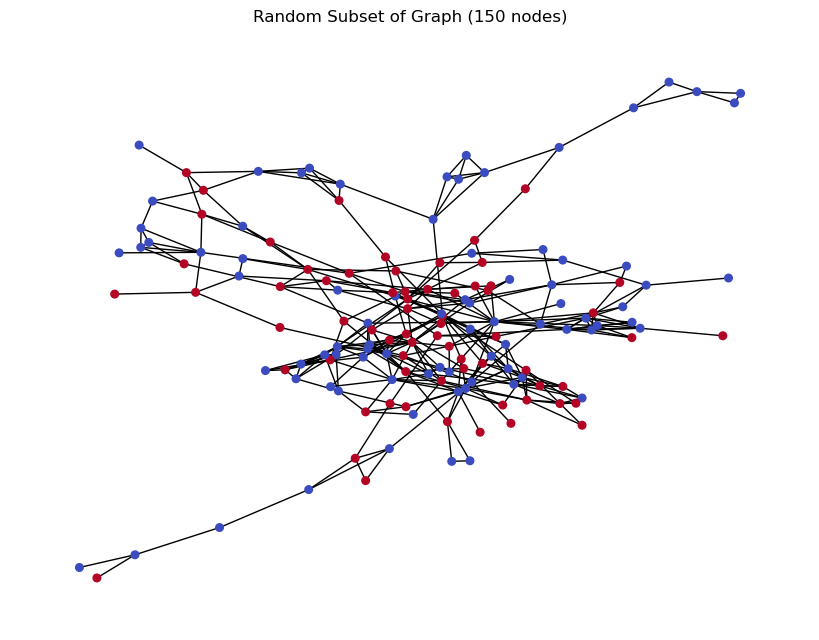

In [1169]:
import random
from torch_geometric.utils import subgraph

# Randomly select N nodes (e.g., 100)
num_nodes_to_plot = 150
subset_nodes = random.sample(range(data.num_nodes), num_nodes_to_plot)

# Extract subgraph
subset_edge_index, _ = subgraph(subset_nodes, data.edge_index, relabel_nodes=True)

# Build subgraph data object
subset_data = Data(x=data.x[subset_nodes], edge_index=subset_edge_index, y=data.y[subset_nodes])

# Convert to NetworkX and visualize
G = to_networkx(subset_data, to_undirected=True)
plt.figure(figsize=(8, 6))
nx.draw(G, node_size=30, node_color=subset_data.y.tolist(), cmap=plt.cm.coolwarm, with_labels=False)
plt.title("Random Subset of Graph (150 nodes)")
plt.savefig("graph.png", dpi=300)
plt.show()

### Train-test split (70-30)

In [1318]:
x_target = torch.tensor(X_smote, dtype=torch.float32)
y_tensor = torch.tensor(y_smote, dtype=torch.long)

In [1321]:
# Train/test split
train_idx, test_idx = train_test_split(np.arange(len(y_smote)), test_size=0.3, stratify=y_smote, random_state=42)
train_mask = torch.zeros(len(y_smote), dtype=torch.bool)
test_mask = torch.zeros(len(y_smote), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

In [1323]:
# PyTorch Geometric format
x = torch.tensor(X_smote, dtype=torch.float32)
y_tensor = torch.tensor(y_smote, dtype=torch.long)
# Build data object
data = Data(x=x, edge_index=edge_index, y=y_tensor)
data.train_mask = train_mask
data.test_mask = test_mask

### Defining the GAT model

In [1326]:
# === Define GAT ===
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=2, concat=True)               # output: hidden_dim * 2
        self.conv_mid = GATConv(hidden_dim * 2, hidden_dim, heads=2, concat=True)       # output: hidden_dim * 2
        self.conv2 = GATConv(hidden_dim * 2, output_dim, heads=1, concat=False)         # output: output_dim

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv_mid(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.conv2(x, edge_index)
        return x


## Model Before SMOTE

In [1490]:
#=== Step 1: Split before SMOTE
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_dmcca, y, test_size=0.3, stratify=y, random_state=42
)

# === Step 2: Combine for full dataset
X_all_raw = np.vstack([X_train_raw, X_test_raw])
y_all_raw = np.concatenate([y_train_raw, y_test_raw])

# === Step 3: Recompute edge_index for raw (pre-SMOTE) data
adj_raw = kneighbors_graph(X_all_raw, n_neighbors=10, mode='distance', include_self=False)
similarities_raw = 1 / (adj_raw.data + 1e-8)
adj_raw.data = similarities_raw
edge_index_raw = torch.tensor(np.vstack(adj_raw.nonzero()), dtype=torch.long)

# === Step 4: Create Data object with raw data
x_raw = torch.tensor(X_all_raw, dtype=torch.float32)
y_tensor_raw = torch.tensor(y_all_raw, dtype=torch.long)
train_mask_raw = torch.zeros(len(y_all_raw), dtype=torch.bool)
test_mask_raw = torch.zeros(len(y_all_raw), dtype=torch.bool)
train_mask_raw[:len(X_train_raw)] = True
test_mask_raw[len(X_train_raw):] = True

data_raw = Data(x=x_raw, edge_index=edge_index_raw, y=y_tensor_raw)
data_raw.train_mask = train_mask_raw
data_raw.test_mask = test_mask_raw

In [1496]:
# === Train GAT ===
model = GAT(input_dim=x_raw.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)
criterion = torch.nn.CrossEntropyLoss()

best_auc = 0.0
patience = 10
counter = 0
best_model_state = None

num_epochs = 100
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    scheduler.step()
    optimizer.zero_grad()
    out = model(data_raw)
    loss = criterion(out[data_raw.train_mask], data_raw.y[data_raw.train_mask])
    loss.backward()
    optimizer.step()

    # === Evaluate on test mask
    model.eval()
    with torch.no_grad():
        logits = model(data_raw)
        probs = F.softmax(logits[data_raw.test_mask], dim=1)[:, 1].cpu().numpy()
        true = data_raw.y[data_raw.test_mask].cpu().numpy()
        auc = roc_auc_score(true, probs)

    preds = out[data_raw.train_mask].argmax(dim=1)
    labels = data_raw.y[data_raw.train_mask]
    acc = (preds == labels).float().mean().item()

    train_losses.append(loss.item())
    train_accuracies.append(acc)
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test AUC: {auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} — Best Test AUC: {best_auc:.4f}")
            break

# Load best model
model.load_state_dict(best_model_state)

C:\Users\arvin\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0, Loss: 0.6732, Test AUC: 0.4098
Epoch 1, Loss: 0.5704, Test AUC: 0.4199
Epoch 2, Loss: 0.6122, Test AUC: 0.4266
Epoch 3, Loss: 0.5878, Test AUC: 0.4223
Epoch 4, Loss: 0.5670, Test AUC: 0.4372
Epoch 5, Loss: 0.5864, Test AUC: 0.4690
Epoch 6, Loss: 0.5898, Test AUC: 0.4844
Epoch 7, Loss: 0.5706, Test AUC: 0.5036
Epoch 8, Loss: 0.5715, Test AUC: 0.5099
Epoch 9, Loss: 0.5747, Test AUC: 0.5180
Epoch 10, Loss: 0.5705, Test AUC: 0.5204
Epoch 11, Loss: 0.5762, Test AUC: 0.5248
Epoch 12, Loss: 0.5656, Test AUC: 0.5301
Epoch 13, Loss: 0.5659, Test AUC: 0.5334
Epoch 14, Loss: 0.5678, Test AUC: 0.5344
Epoch 15, Loss: 0.5650, Test AUC: 0.5387
Epoch 16, Loss: 0.5723, Test AUC: 0.5397
Epoch 17, Loss: 0.5670, Test AUC: 0.5411
Epoch 18, Loss: 0.5569, Test AUC: 0.5411
Epoch 19, Loss: 0.5617, Test AUC: 0.5411
Epoch 20, Loss: 0.5593, Test AUC: 0.5426
Epoch 21, Loss: 0.5659, Test AUC: 0.5430
Epoch 22, Loss: 0.5669, Test AUC: 0.5430
Epoch 23, Loss: 0.5653, Test AUC: 0.5440
Epoch 24, Loss: 0.5616, Te

<All keys matched successfully>

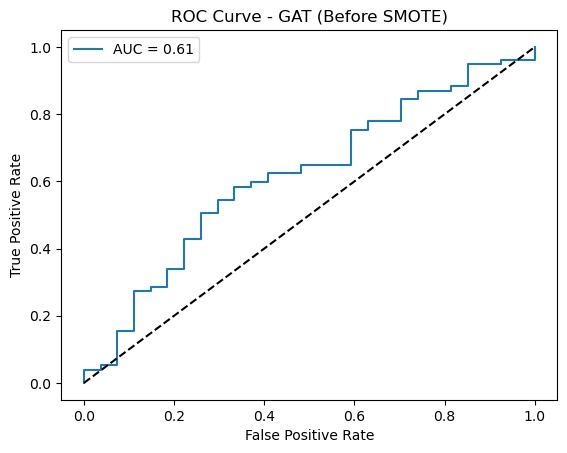

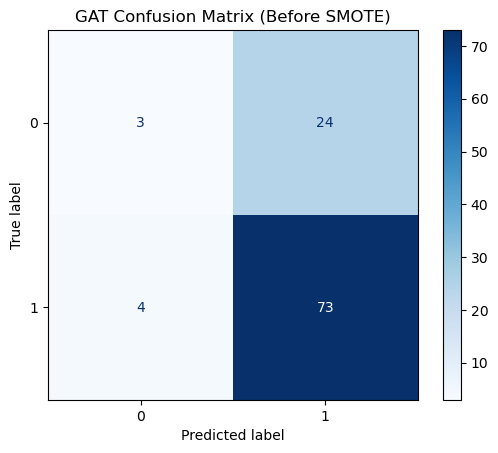

Accuracy       : 0.7308
Precision      : 0.7526
Recall         : 0.9481
F1 Score       : 0.8391
AUC (ROC)      : 0.6147


In [1498]:
# === Evaluate GAT on raw data ===
model.eval()
with torch.no_grad():
    logits_raw = model(data_raw)
    preds_raw = logits_raw.argmax(dim=1)
    probs_raw = F.softmax(logits_raw, dim=1)[:, 1]  # Probabilities for class 1

# Convert to numpy
probs_np_raw = probs_raw[data_raw.test_mask].cpu().numpy()
true_labels_raw = data_raw.y[data_raw.test_mask].cpu().numpy()
pred_labels_raw = preds_raw[data_raw.test_mask].cpu().numpy()

# === ROC Curve & AUC
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
fpr_raw, tpr_raw, _ = roc_curve(true_labels_raw, probs_np_raw)
roc_auc_raw = auc(fpr_raw, tpr_raw)

plt.figure()
plt.plot(fpr_raw, tpr_raw, label=f"AUC = {roc_auc_raw:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAT (Before SMOTE)")
plt.legend()
plt.savefig("gat_roc_raw.png", dpi=300)
plt.show()

# === Confusion Matrix
cm_raw = confusion_matrix(true_labels_raw, pred_labels_raw)
disp_raw = ConfusionMatrixDisplay(confusion_matrix=cm_raw)
disp_raw.plot(cmap="Blues", values_format='d')
plt.title("GAT Confusion Matrix (Before SMOTE)")
plt.savefig("gat_confmat_raw.png", dpi=300)
plt.show()

# === Classification Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_raw = accuracy_score(true_labels_raw, pred_labels_raw)
precision_raw = precision_score(true_labels_raw, pred_labels_raw)
recall_raw = recall_score(true_labels_raw, pred_labels_raw)
f1_raw = f1_score(true_labels_raw, pred_labels_raw)

print(f"Accuracy       : {accuracy_raw:.4f}")
print(f"Precision      : {precision_raw:.4f}")
print(f"Recall         : {recall_raw:.4f}")
print(f"F1 Score       : {f1_raw:.4f}")
print(f"AUC (ROC)      : {roc_auc_raw:.4f}")


In [1448]:
# === Train GAT ===
model = GAT(input_dim=X_dmcca.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)  # decay LR by 0.9 every 10 epochs

## Model After SMOTE

In [1412]:
# === Train GAT ===
model = GAT(input_dim=x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)  # decay LR by 0.9 every 10 epochs


In [1346]:
criterion = torch.nn.CrossEntropyLoss()

# === Early stopping settings
best_auc = 0.0
patience = 10
counter = 0
best_model_state = None

num_epochs = 100
train_losses = []
train_accuracies = []
for epoch in range(num_epochs):
    model.train()
    scheduler.step()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    # === Evaluate on test mask
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits[data.test_mask], dim=1)[:, 1].cpu().numpy()
        true = data.y[data.test_mask].cpu().numpy()
        auc = roc_auc_score(true, probs)
    preds = out[data.train_mask].argmax(dim=1)
    labels = data.y[data.train_mask]
    acc = (preds == labels).float().mean().item()

    train_losses.append(loss.item())
    train_accuracies.append(acc)
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}, Test AUC: {auc:.4f}")

    # === Early stopping check
    if auc > best_auc:
        best_auc = auc
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch} — Best Test AUC: {best_auc:.4f}")
            break

# === Load the best model
model.load_state_dict(best_model_state)

C:\Users\arvin\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0, Loss: 0.6940, Test AUC: 0.6066
Epoch 1, Loss: 0.6918, Test AUC: 0.6203
Epoch 2, Loss: 0.7434, Test AUC: 0.6300
Epoch 3, Loss: 0.6828, Test AUC: 0.6350
Epoch 4, Loss: 0.7132, Test AUC: 0.6352
Epoch 5, Loss: 0.6936, Test AUC: 0.6350
Epoch 6, Loss: 0.6819, Test AUC: 0.6355
Epoch 7, Loss: 0.6937, Test AUC: 0.6343
Epoch 8, Loss: 0.6876, Test AUC: 0.6335
Epoch 9, Loss: 0.6825, Test AUC: 0.6336
Epoch 10, Loss: 0.6779, Test AUC: 0.6333
Epoch 11, Loss: 0.6810, Test AUC: 0.6336
Epoch 12, Loss: 0.6812, Test AUC: 0.6357
Epoch 13, Loss: 0.6747, Test AUC: 0.6357
Epoch 14, Loss: 0.6699, Test AUC: 0.6357
Epoch 15, Loss: 0.6669, Test AUC: 0.6369
Epoch 16, Loss: 0.6655, Test AUC: 0.6389
Epoch 17, Loss: 0.6588, Test AUC: 0.6400
Epoch 18, Loss: 0.6552, Test AUC: 0.6403
Epoch 19, Loss: 0.6524, Test AUC: 0.6415
Epoch 20, Loss: 0.6520, Test AUC: 0.6422
Epoch 21, Loss: 0.6399, Test AUC: 0.6459
Epoch 22, Loss: 0.6382, Test AUC: 0.6468
Epoch 23, Loss: 0.6390, Test AUC: 0.6480
Epoch 24, Loss: 0.6265, Te

<All keys matched successfully>

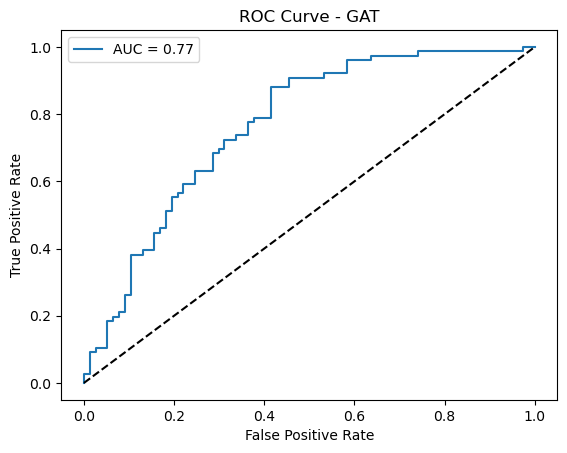

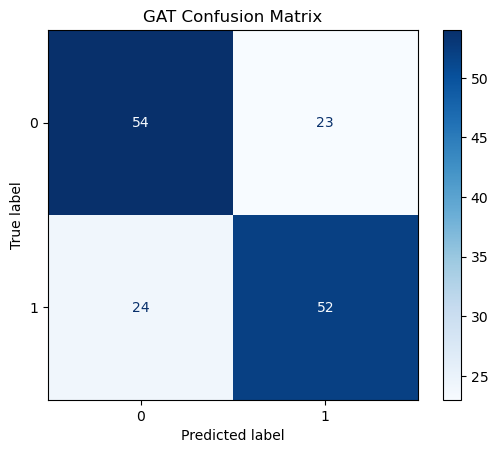

Accuracy       : 0.6928
Precision      : 0.6933
Recall         : 0.6842
F1 Score       : 0.6887
AUC (ROC)      : 0.7659


In [1348]:
# === Evaluate GAT ===
model.eval()
with torch.no_grad():
    logits = model(data)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1

# Convert to numpy
probs_np = probs[data.test_mask].cpu().numpy()
true_labels = data.y[data.test_mask].cpu().numpy()
pred_labels = preds[data.test_mask].cpu().numpy()

# === ROC Curve & AUC
fpr, tpr, _ = roc_curve(true_labels, probs_np)
# Use sklearn.metrics.auc instead of the overwritten variable
from sklearn.metrics import auc  # Make sure auc is imported
roc_auc_smote = auc(fpr, tpr) # Changed the variable name to 'roc_auc_score'

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_smote:.2f}") # Use the new variable name here
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAT")
plt.legend()
plt.savefig("gat_roc.png", dpi=300)
plt.show()

# === Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("GAT Confusion Matrix")
plt.savefig("gat_confmat.png", dpi=300)
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"AUC (ROC)      : {roc_auc_smote:.4f}")

## Saving model

In [1110]:
best_model_state = model.state_dict()
torch.save(best_model_state, "best_gat_model.pt")

## Loading the model from saved

In [ ]:
model = GAT(input_dim=x.shape[1])
model.load_state_dict(torch.load("best_gat_model.pt"))
model.eval()

with torch.no_grad():
    logits = model(data)
    preds = logits.argmax(dim=1)
    probs = F.softmax(logits, dim=1)[:, 1]  # Probabilities for class 1

# Convert to numpy
probs_np = probs[data.test_mask].cpu().numpy()
true_labels = data.y[data.test_mask].cpu().numpy()
pred_labels = preds[data.test_mask].cpu().numpy()

# === ROC Curve & AUC
fpr, tpr, _ = roc_curve(true_labels, probs_np)
# Use sklearn.metrics.auc instead of the overwritten variable
from sklearn.metrics import auc  # Make sure auc is imported
roc_auc_smote = auc(fpr, tpr) # Changed the variable name to 'roc_auc_score'

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_smote:.2f}") # Use the new variable name here
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - GAT")
plt.legend()
plt.show()

# === Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format='d')
plt.title("GAT Confusion Matrix")
plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

print(f"Accuracy       : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {f1:.4f}")
print(f"AUC (ROC)      : {roc_auc_smote:.4f}")

## Evaluating the shared latent space

In [1374]:
model.eval()
with torch.no_grad():
    x = model.conv1(data.x, data.edge_index)
    x = F.elu(x)
    x = F.dropout(x, p=0.4, training=False)
    
    latent = model.conv_mid(x, data.edge_index)  # Shape: [510, features]
    latent = F.elu(latent)
    shared_latent_np = latent.cpu().numpy()  # Shape: [510, ?]

labels = data.y.cpu().numpy()

In [1376]:
from sklearn.metrics import silhouette_score
from sklearn.manifold import trustworthiness

# Silhouette Score (for cluster separation)
sil_score = silhouette_score(shared_latent_np, labels)
print(f"Silhouette Score (Full Data): {sil_score:.4f}")

# Trustworthiness (for local neighborhood preservation)
trust = trustworthiness(X_smote, shared_latent_np, n_neighbors=10)
print(f"Trustworthiness: {trust:.4f}")


Silhouette Score (Full Data): 0.0329
Trustworthiness: 0.9615


In [1378]:
mask = data.test_mask.cpu().numpy()  # or train_mask, depending on what you're using
Z_subset = shared_latent_np[mask]
labels_subset = labels[mask]

from sklearn.manifold import trustworthiness
trust = trustworthiness(X_smote, shared_latent_np, n_neighbors=10)
print(f"Trustworthiness: {trust:.4f}")


Trustworthiness: 0.9615


## Visualizing the shared latent space after dimensionality reduction using UMAP

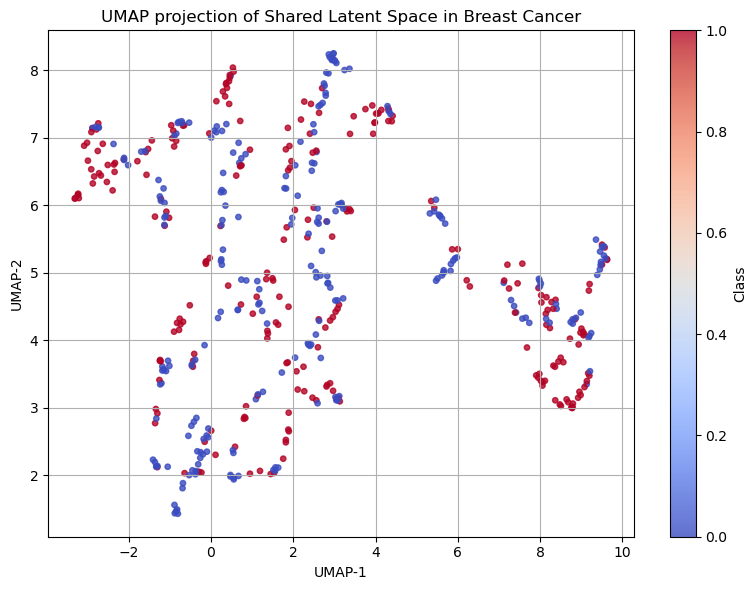

In [1408]:
import umap.umap_ as umap
import matplotlib.pyplot as plt

umap_proj = umap.UMAP(n_neighbors=15).fit_transform(shared_latent_np)

plt.figure(figsize=(8,6))
plt.scatter(umap_proj[:,0], umap_proj[:,1], c=labels, cmap='coolwarm', s=15, alpha=0.8)
plt.title("UMAP projection of Shared Latent Space in Breast Cancer")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(label='Class')
plt.grid(True)
plt.tight_layout()
plt.savefig("umap_brca.png", dpi=600)
plt.show()


In [1388]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

clf = LogisticRegression()
clf.fit(shared_latent_np[train_mask], labels[train_mask])
probs = clf.predict_proba(shared_latent_np[test_mask])[:, 1]
preds = clf.predict(shared_latent_np[test_mask])

print("AUC:", roc_auc_score(labels[test_mask], probs))
print("Accuracy:", accuracy_score(labels[test_mask], preds))

AUC: 0.6561859193438141
Accuracy: 0.5816993464052288


In [1392]:
dmcca.eval()
with torch.no_grad():
    zs = dmcca([X_mdna_tensor, X_mge_tensor, X_mcna_tensor])  # List of [z_mdna, z_mge, z_mcna]
    z_joint = dmcca.get_joint_embedding(zs)  # Combine into shared latent space (shape: [batch, latent_dim])
    recons = dmcca.reconstruct(z_joint)     # Decode the joint embedding

import torch.nn.functional as F

loss_mdna = F.mse_loss(recons[0], X_mdna_tensor)
loss_mge  = F.mse_loss(recons[1], X_mge_tensor)
loss_mcna = F.mse_loss(recons[2], X_mcna_tensor)
avg_loss  = (loss_mdna + loss_mge + loss_mcna) / 3

print(f"Reconstruction Loss (mDNA): {loss_mdna.item():.4f}")
print(f"Reconstruction Loss (GE):   {loss_mge.item():.4f}")
print(f"Reconstruction Loss (CNA):  {loss_mcna.item():.4f}")
print(f"Average Reconstruction Loss: {avg_loss.item():.4f}")

Reconstruction Loss (mDNA): 0.1812
Reconstruction Loss (GE):   0.0798
Reconstruction Loss (CNA):  0.2488
Average Reconstruction Loss: 0.1699


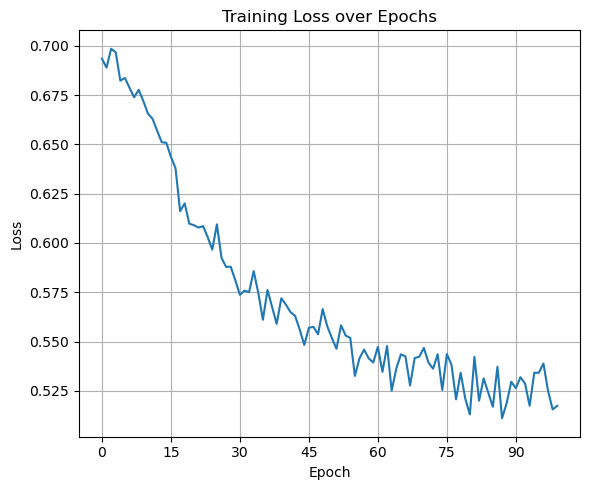

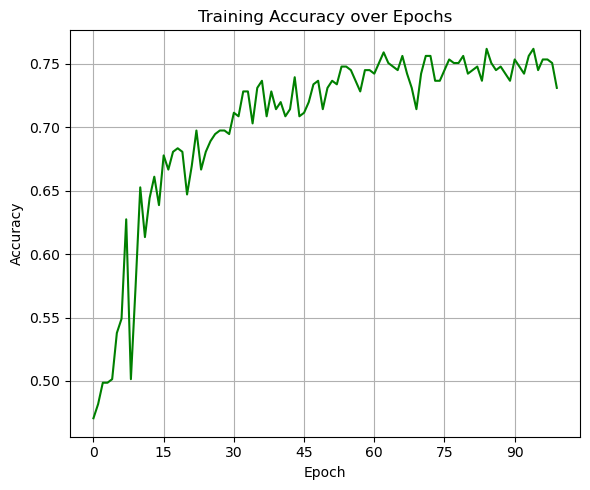

In [1043]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(6, 5))
plt.plot(train_losses, label='Loss')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.tight_layout()
plt.savefig("training_loss.png", dpi=300)
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 
plt.tight_layout()
plt.savefig("training_accuracy.png", dpi=300)
plt.show()

### k-fold cross validation

In [495]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store fold results
cv_auc = []
cv_acc = []
cv_f1 = []


=== Fold 1 ===
AUC: 0.7277, Accuracy: 0.6863, F1: 0.7037

=== Fold 2 ===
AUC: 0.7431, Accuracy: 0.6667, F1: 0.6909

=== Fold 3 ===
AUC: 0.8185, Accuracy: 0.7451, F1: 0.7547

=== Fold 4 ===
AUC: 0.8723, Accuracy: 0.7647, F1: 0.8065

=== Fold 5 ===
AUC: 0.6938, Accuracy: 0.6078, F1: 0.6000

=== Fold 6 ===
AUC: 0.8385, Accuracy: 0.7059, F1: 0.7692

=== Fold 7 ===
AUC: 0.6815, Accuracy: 0.6667, F1: 0.7018

=== Fold 8 ===
AUC: 0.8200, Accuracy: 0.7843, F1: 0.7843

=== Fold 9 ===
AUC: 0.7723, Accuracy: 0.7059, F1: 0.7170

=== Fold 10 ===
AUC: 0.7585, Accuracy: 0.7255, F1: 0.7308


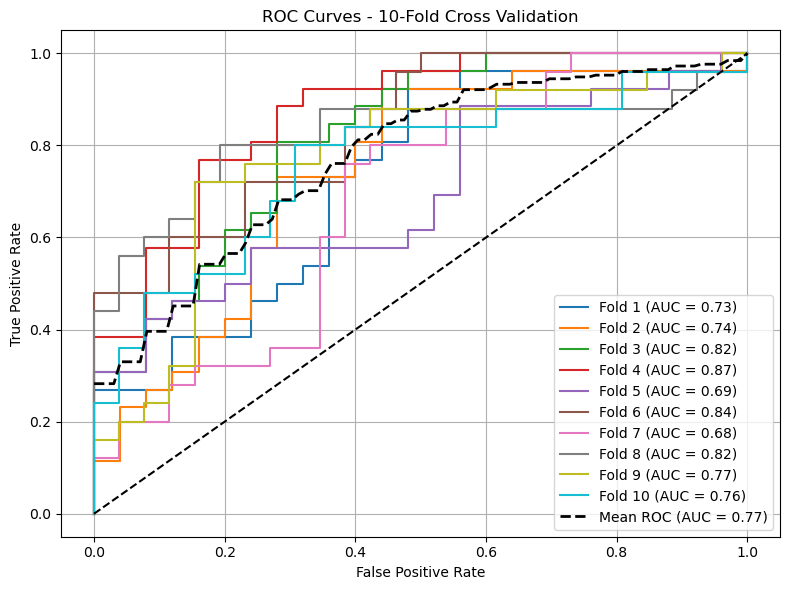


=== 10-Fold CV Summary ===
Average AUC      : 0.7726
Average Accuracy : 0.7059
Average F1 Score : 0.7259


In [499]:
# === Build the graph ONCE
adj = kneighbors_graph(X, n_neighbors=10, mode='distance', include_self=False)
adj.data = 1 / (adj.data + 1e-8)
edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

# === Use 10-Fold Stratified CV
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Storage for metrics
cv_auc, cv_acc, cv_f1 = [], [], []
fprs, tprs, roc_aucs = [], [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    data = Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long),
        train_mask=train_mask,
        test_mask=test_mask
    )

    model = GAT(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(60):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)

    probs_np = probs[test_mask].cpu().numpy()
    true_labels = data.y[test_mask].cpu().numpy()
    pred_labels = preds[test_mask].cpu().numpy()

    auc_score = roc_auc_score(true_labels, probs_np)
    acc = accuracy_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"AUC: {auc_score:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}")

    cv_auc.append(auc_score)
    cv_acc.append(acc)
    cv_f1.append(f1)

    fpr, tpr, _ = roc_curve(true_labels, probs_np)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

# === Plot Combined ROC Curves
plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fprs[i], tprs[i], label=f'Fold {i+1} (AUC = {roc_aucs[i]:.2f})')

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(10)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='black', linestyle='--', linewidth=2,
         label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - 10-Fold Cross Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Final Summary
print("\n=== 10-Fold CV Summary ===")
print(f"Average AUC      : {np.mean(cv_auc):.4f}")
print(f"Average Accuracy : {np.mean(cv_acc):.4f}")
print(f"Average F1 Score : {np.mean(cv_f1):.4f}")

### Combined 5 or 10 fold cross validation

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score, accuracy_score, f1_score
)
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data

# === Build the Graph ONCE (kNN)
adj = kneighbors_graph(X, n_neighbors=10, mode='distance', include_self=False)
adj.data = 1 / (adj.data + 1e-8)  # Inverse distance as similarity
edge_index = torch.tensor(np.vstack(adj.nonzero()), dtype=torch.long)

all_probs = []
all_true_labels = []

# === Stratified 10-Fold CV
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Metric Storage
cv_auc, cv_acc, cv_f1 = [], [], []
fprs, tprs, roc_aucs = [], [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
    print(f"\n=== Fold {fold+1} ===")

    # Masks
    train_mask = torch.zeros(len(y), dtype=torch.bool)
    test_mask = torch.zeros(len(y), dtype=torch.bool)
    train_mask[train_idx] = True
    test_mask[test_idx] = True

    # PyG Data object
    data = Data(
        x=torch.tensor(X, dtype=torch.float32),
        edge_index=edge_index,
        y=torch.tensor(y, dtype=torch.long),
        train_mask=train_mask,
        test_mask=test_mask
    )

    # GAT Model
    model = GAT(input_dim=X.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    # === Training
    for epoch in range(60):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

    # === Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(data)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = logits.argmax(dim=1)

    # === Collect predictions and true labels for this fold
    all_probs.extend(probs[test_mask].cpu().numpy())
    all_true_labels.extend(data.y[test_mask].cpu().numpy())

    # Optionally still compute per-fold AUC for logging
    auc_score = roc_auc_score(data.y[test_mask].cpu().numpy(), probs[test_mask].cpu().numpy())
    print(f"Fold {fold+1} AUC: {auc_score:.4f}")

    cv_auc.append(auc_score)
    cv_acc.append(acc)
    cv_f1.append(f1)

    fpr, tpr, _ = roc_curve(true_labels, probs_np)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

## === Final ROC Curve (Combined from all folds)
fpr, tpr, _ = roc_curve(all_true_labels, all_probs)
combined_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Combined ROC (AUC = {combined_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Combined 10-Fold Cross Validation")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("combined_10fold_roc.png", dpi=300)
plt.show()


### Training GAT before SMOTE

In [ ]:
data = build_graph_data(X_raw, y_raw)
model = GAT(input_dim=X_raw.shape[1])

### Taking the data before SMOTE

In [733]:
X_train = data.x[data.train_mask].cpu().numpy()
X_test = data.x[data.test_mask].cpu().numpy()
y_train = data.y[data.train_mask].cpu().numpy()
y_test = data.y[data.test_mask].cpu().numpy()

In [1073]:
X_raw = X_dmcca
y_raw = y

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.3, stratify=y_raw, random_state=42
)

### ANN Before SMOTE

In [1087]:
import torch.nn as nn
import torch.optim as optim

class ANN(nn.Module):
    def __init__(self, input_dim):
        super(ANN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.layers(x)

model_ann = ANN(input_dim=X_train_raw.shape[1])
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train_raw, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_raw, dtype=torch.float32)

# Train
for epoch in range(50):
    model_ann.train()
    optimizer.zero_grad()
    out = model_ann(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict
model_ann.eval()
with torch.no_grad():
    logits = model_ann(X_test_tensor)
    probs_ann = F.softmax(logits, dim=1)[:, 1].numpy()
    preds_ann = logits.argmax(dim=1).numpy()

ann_auc = roc_auc_score(y_test_raw, probs_ann)
print(f"[ANN Before SMOTE] AUC: {ann_auc:.4f}, Accuracy: {accuracy_score(y_test_raw, preds_ann):.4f}")


[ANN Before SMOTE] AUC: 0.5921, Accuracy: 0.7404


### ANN After SMOTE

In [1091]:
model_ann = ANN(input_dim=X_train.shape[1])
optimizer = optim.Adam(model_ann.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Train
for epoch in range(50):
    model_ann.train()
    optimizer.zero_grad()
    out = model_ann(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predict
model_ann.eval()
with torch.no_grad():
    logits = model_ann(X_test_tensor)
    probs_ann = F.softmax(logits, dim=1)[:, 1].numpy()
    preds_ann = logits.argmax(dim=1).numpy()

ann_auc = roc_auc_score(y_test, probs_ann)
print(f"[ANN After SMOTE] AUC: {ann_auc:.4f}, Accuracy: {accuracy_score(y_test, preds_ann):.4f}")


[ANN After SMOTE] AUC: 0.6738, Accuracy: 0.6863


### Logistic Regression before SMOTE

In [1093]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve
)

lr_raw = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_raw.fit(X_train_raw, y_train_raw)

probs_raw = lr_raw.predict_proba(X_test_raw)[:, 1]
preds_raw = lr_raw.predict(X_test_raw)

print("\n Before SMOTE:")
print(f"[Logistic Regression] AUC       : {roc_auc_score(y_test_raw, probs_raw):.4f}")
print(f"[Logistic Regression] Accuracy  : {accuracy_score(y_test_raw, preds_raw):.4f}")
print(f"[Logistic Regression] F1 Score  : {f1_score(y_test_raw, preds_raw):.4f}")


 Before SMOTE:
[Logistic Regression] AUC       : 0.5411
[Logistic Regression] Accuracy  : 0.5865
[Logistic Regression] F1 Score  : 0.6906


### Logistic Regression after SMOTE

In [1096]:
# Initialize logistic regression with balanced class weights
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train, y_train)

# Predict probabilities and labels
lr_probs = lr.predict_proba(X_test)[:, 1]
lr_preds = lr.predict(X_test)

# Compute metrics
lr_auc = roc_auc_score(y_test, lr_probs)
lr_acc = accuracy_score(y_test, lr_preds)
lr_f1 = f1_score(y_test, lr_preds)
lr_precision = precision_score(y_test, lr_preds)
lr_recall = recall_score(y_test, lr_preds)

# Print results
print("\n After SMOTE:")
print(f"[Logistic Regression] AUC       : {lr_auc:.4f}")
print(f"[Logistic Regression] Accuracy  : {lr_acc:.4f}")
print(f"[Logistic Regression] Precision : {lr_precision:.4f}")
print(f"[Logistic Regression] Recall    : {lr_recall:.4f}")
print(f"[Logistic Regression] F1 Score  : {lr_f1:.4f}")



 After SMOTE:
[Logistic Regression] AUC       : 0.6862
[Logistic Regression] Accuracy  : 0.6078
[Logistic Regression] Precision : 0.6087
[Logistic Regression] Recall    : 0.5600
[Logistic Regression] F1 Score  : 0.5833


### Transformer before SMOTE

In [1100]:
import torch.nn as nn
import torch

class TabularTransformer(nn.Module):
    def __init__(self, input_dim, num_classes=2, num_heads=4, num_layers=2, dim_feedforward=128):
        super(TabularTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, input_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # [batch_size, seq_len=1, dim]
        x = self.encoder(x)
        x = x.squeeze(1)
        return self.classifier(x)

model = TabularTransformer(input_dim=X_train_raw.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train_raw, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_raw, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_raw, dtype=torch.float32)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = nn.functional.softmax(logits, dim=1)[:, 1].numpy()
    preds = logits.argmax(dim=1).numpy()

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt

auc_score = roc_auc_score(y_test_raw, probs)
acc = accuracy_score(y_test_raw, preds)
f1 = f1_score(y_test_raw, preds)
precision = precision_score(y_test_raw, preds)
recall = recall_score(y_test_raw, preds)

print("Before SMOTE: ")
print(f"[Transformer] AUC       : {auc_score:.4f}")
print(f"[Transformer] Accuracy  : {acc:.4f}")
print(f"[Transformer] Precision : {precision:.4f}")
print(f"[Transformer] Recall    : {recall:.4f}")
print(f"[Transformer] F1 Score  : {f1:.4f}")

Before SMOTE: 
[Transformer] AUC       : 0.5546
[Transformer] Accuracy  : 0.7404
[Transformer] Precision : 0.7404
[Transformer] Recall    : 1.0000
[Transformer] F1 Score  : 0.8508


### Transformer after SMOTE

In [1104]:
model = TabularTransformer(input_dim=X_train_raw.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Training loop
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor)
    probs = nn.functional.softmax(logits, dim=1)[:, 1].numpy()
    preds = logits.argmax(dim=1).numpy()

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt

auc_score = roc_auc_score(y_test, probs)
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)

print("After SMOTE: ")
print(f"[Transformer] AUC       : {auc_score:.4f}")
print(f"[Transformer] Accuracy  : {acc:.4f}")
print(f"[Transformer] Precision : {precision:.4f}")
print(f"[Transformer] Recall    : {recall:.4f}")
print(f"[Transformer] F1 Score  : {f1:.4f}")

After SMOTE: 
[Transformer] AUC       : 0.8000
[Transformer] Accuracy  : 0.6863
[Transformer] Precision : 0.6552
[Transformer] Recall    : 0.7600
[Transformer] F1 Score  : 0.7037


In [1507]:
print("X_dmcca:", X_dmcca.shape)
print("y:", len(y))
print("X_smote:", X_smote.shape)
print("y_smote:", len(y_smote))

X_dmcca: (344, 64)
y: 344
X_smote: (510, 64)
y_smote: 510
